# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [6]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/Users/inmilk306/Documents/GitHub_polinacsv/DX603-Milestone-1/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [10]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [11]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [20]:
df.shape

(77613, 55)

In [22]:
# Basic data info
df_info = pd.DataFrame({
    "Data Type": df.dtypes,
    "Missing (%)": df.isnull().mean() * 100,
    "Unique Values": df.nunique()
})

# Reset index to turn column names into a column
df_info = df_info.reset_index().rename(columns={"index": "Feature"})

# Sort by most missing
df_info = df_info.sort_values(by="Missing (%)", ascending=False)

df_info


,Feature,Data Type,Missing (%),Unique Values
6,buildingclasstypeid,float64,99.980673,2
13,finishedsquarefeet13,float64,99.945885,13
41,storytypeid,float64,99.935578,1
3,basementsqft,float64,99.935578,43
46,yardbuildingsqft26,float64,99.909809,59
49,fireplaceflag,object,99.778388,1
2,architecturalstyletypeid,float64,99.733292,5
43,typeconstructiontypeid,float64,99.712677,4
16,finishedsquarefeet6,float64,99.502661,350
29,pooltypeid10,float64,99.400874,1


In [29]:
# Load data dictionary
data_dict = pd.read_excel("zillow_data_dictionary.xlsx")

# Standardize column names
df_info['Feature'] = df_info['Feature'].str.lower()
data_dict.columns = [col.lower().strip() for col in data_dict.columns]
data_dict['feature'] = data_dict['feature'].str.lower().str.strip("'").str.strip('"').str.strip()

# Merge summary with dictionary
merged = pd.merge(df_info, data_dict, left_on='Feature', right_on='feature', how='left')

# Function to assess each feature
def assess_feature(row):
    if row['Missing (%)'] > 80:
        return "Likely Drop (Too Many Missing)"
    elif row['Unique Values'] <= 1:
        return "Drop (No Variance)"
    elif row['Feature'] == 'taxvaluedollarcnt':
        return "Target"
    else:
        return "Keep/Investigate"

# Apply the assessment
merged['Preliminary Assessment'] = merged.apply(assess_feature, axis=1)
merged = merged.drop(columns=['feature'])
merged.sort_values(by="Missing (%)", ascending=False)


,Feature,Data Type,Missing (%),Unique Values,description,Preliminary Assessment
0,buildingclasstypeid,float64,99.980673,2,"The building framing type (steel frame, wood f...",Likely Drop (Too Many Missing)
1,finishedsquarefeet13,float64,99.945885,13,Perimeter living area,Likely Drop (Too Many Missing)
2,storytypeid,float64,99.935578,1,Type of floors in a multi-story house (i.e. b...,Likely Drop (Too Many Missing)
3,basementsqft,float64,99.935578,43,Finished living area below or partially below...,Likely Drop (Too Many Missing)
4,yardbuildingsqft26,float64,99.909809,59,Storage shed/building in yard,Likely Drop (Too Many Missing)
5,fireplaceflag,object,99.778388,1,Is a fireplace present in this home,Likely Drop (Too Many Missing)
6,architecturalstyletypeid,float64,99.733292,5,"Architectural style of the home (i.e. ranch, ...",Likely Drop (Too Many Missing)
7,typeconstructiontypeid,float64,99.712677,4,What type of construction material was used t...,Likely Drop (Too Many Missing)
8,finishedsquarefeet6,float64,99.502661,350,Base unfinished and finished area,Likely Drop (Too Many Missing)
9,pooltypeid10,float64,99.400874,1,Spa or Hot Tub,Likely Drop (Too Many Missing)


In [32]:
# Reload the merged feature list to get the object column names
object_feature_names = merged[merged["Data Type"] == "object"]["Feature"].tolist()

# Create a dictionary of unique values for each object column
object_uniques = {}

for col in object_feature_names:
    if col in df.columns:
        unique_vals = df[col].dropna().unique()
        object_uniques[col] = unique_vals[:10]  # Limit to first 10 unique values for display

# Convert to DataFrame for display
object_uniques_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in object_uniques.items()]))

object_uniques_df

,fireplaceflag,hashottuborspa,taxdelinquencyflag,propertyzoningdesc,propertycountylandusecode
0,True,True,Y,LCR110000*,122
1,NaN,NaN,NaN,LAR3,1110
2,NaN,NaN,NaN,PSR2,0101
3,NaN,NaN,NaN,GLR4YY,010C
4,NaN,NaN,NaN,WHRE20000*,1129
5,NaN,NaN,NaN,SCUR2,0100
6,NaN,NaN,NaN,GLR3*,38
7,NaN,NaN,NaN,LCR2YY,34
8,NaN,NaN,NaN,PARM*,1111
9,NaN,NaN,NaN,LAC2,012C


In [34]:
# Filter for features preliminarily flagged as likely to be dropped
to_drop = merged[merged["Preliminary Assessment"].str.startswith("Drop") | 
                 merged["Preliminary Assessment"].str.startswith("Likely Drop")]

to_drop


,Feature,Data Type,Missing (%),Unique Values,description,Preliminary Assessment
0,buildingclasstypeid,float64,99.980673,2,"The building framing type (steel frame, wood f...",Likely Drop (Too Many Missing)
1,finishedsquarefeet13,float64,99.945885,13,Perimeter living area,Likely Drop (Too Many Missing)
2,storytypeid,float64,99.935578,1,Type of floors in a multi-story house (i.e. b...,Likely Drop (Too Many Missing)
3,basementsqft,float64,99.935578,43,Finished living area below or partially below...,Likely Drop (Too Many Missing)
4,yardbuildingsqft26,float64,99.909809,59,Storage shed/building in yard,Likely Drop (Too Many Missing)
5,fireplaceflag,object,99.778388,1,Is a fireplace present in this home,Likely Drop (Too Many Missing)
6,architecturalstyletypeid,float64,99.733292,5,"Architectural style of the home (i.e. ranch, ...",Likely Drop (Too Many Missing)
7,typeconstructiontypeid,float64,99.712677,4,What type of construction material was used t...,Likely Drop (Too Many Missing)
8,finishedsquarefeet6,float64,99.502661,350,Base unfinished and finished area,Likely Drop (Too Many Missing)
9,pooltypeid10,float64,99.400874,1,Spa or Hot Tub,Likely Drop (Too Many Missing)


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

The categorical features in the dataset include `hashottuborspa`, `fireplaceflag`, and `taxdelinquencyflag`, each of which contains only a single unique value (True or Y). While one could assume that missing entries imply the opposite (i.e., False or N), this would introduce an assumption that may not be valid. Additionally, imputing them would result in highly unbalanced features with limited predictive power. For these reasons, they are better dropped from the dataset. The remaining categorical features, `propertyzoningdesc` and `propertycountylandusecode`, contain zoning and land use information, but their interpretation and encoding would require domain knowledge. Given this complexity, these features will also be dropped from further analysis.


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

Several features are being dropped due to limited business usefulness or redundancy. Both `calculatedbathnbr` and `fullbathcnt` overlap with bathroomcnt, which already captures total bathroom information more consistently. The unitcnt column, which indicates the number of housing units on a property, is often missing and adds little value for single-family homes, which dominate this dataset. We are also dropping `taxvaluedollarcnt`, `structuretaxvaluedollarcnt`, and `landtaxvaluedollarcnt` to avoid data leakage, as these are either the target or direct components of it. Lastly, `airconditioningtypeid`, `heatingorsystemtypeid`, and `buildingqualitytypeid` have high missingness and use internal codes that are difficult to interpret without reliable mappings. Given these issues, they are unlikely to add meaningful predictive value and will be removed.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

To streamline the dataset and focus on features most relevant for predicting property tax value, we will drop all features with more than 80% missing values or only one unique value, as they are either too sparse to be useful or provide no variability for modeling. This includes features like `finishedsquarefeet13`, `basementsqft`, and `storytypeid`.

An exception will be made for two features: `fireplacecnt` and `poolcnt`. Although these also have high missingness, we believe their presence or absence could still provide meaningful signals. Rather than imputing with averages or medians, we will treat them as binary flags—indicating whether or not a property has a fireplace or pool. Missing values for these columns will be filled with 0, representing the absence of the feature.

This strategy balances cleaning with preserving potential signal from sparse but interpretable features.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes, some features appear to be useless due to their high number of unique values, which makes them difficult to interpret or leverage effectively in modeling. A key example is `censustractandblock`, which contains a unique identifier for each census tract and block combination. While this feature could be useful for merging with external census data (e.g., to enrich the dataset with demographic or socioeconomic indicators), that type of spatial enrichment does not appear to be a goal of this project. As such, we will proceed with dropping it to simplify the dataset.

Similarly, features like `latitude`, `longitude`, and `regionidneighborhood` have high cardinality and are difficult to utilize effectively without additional spatial processing or mapping, so they will also be dropped.


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

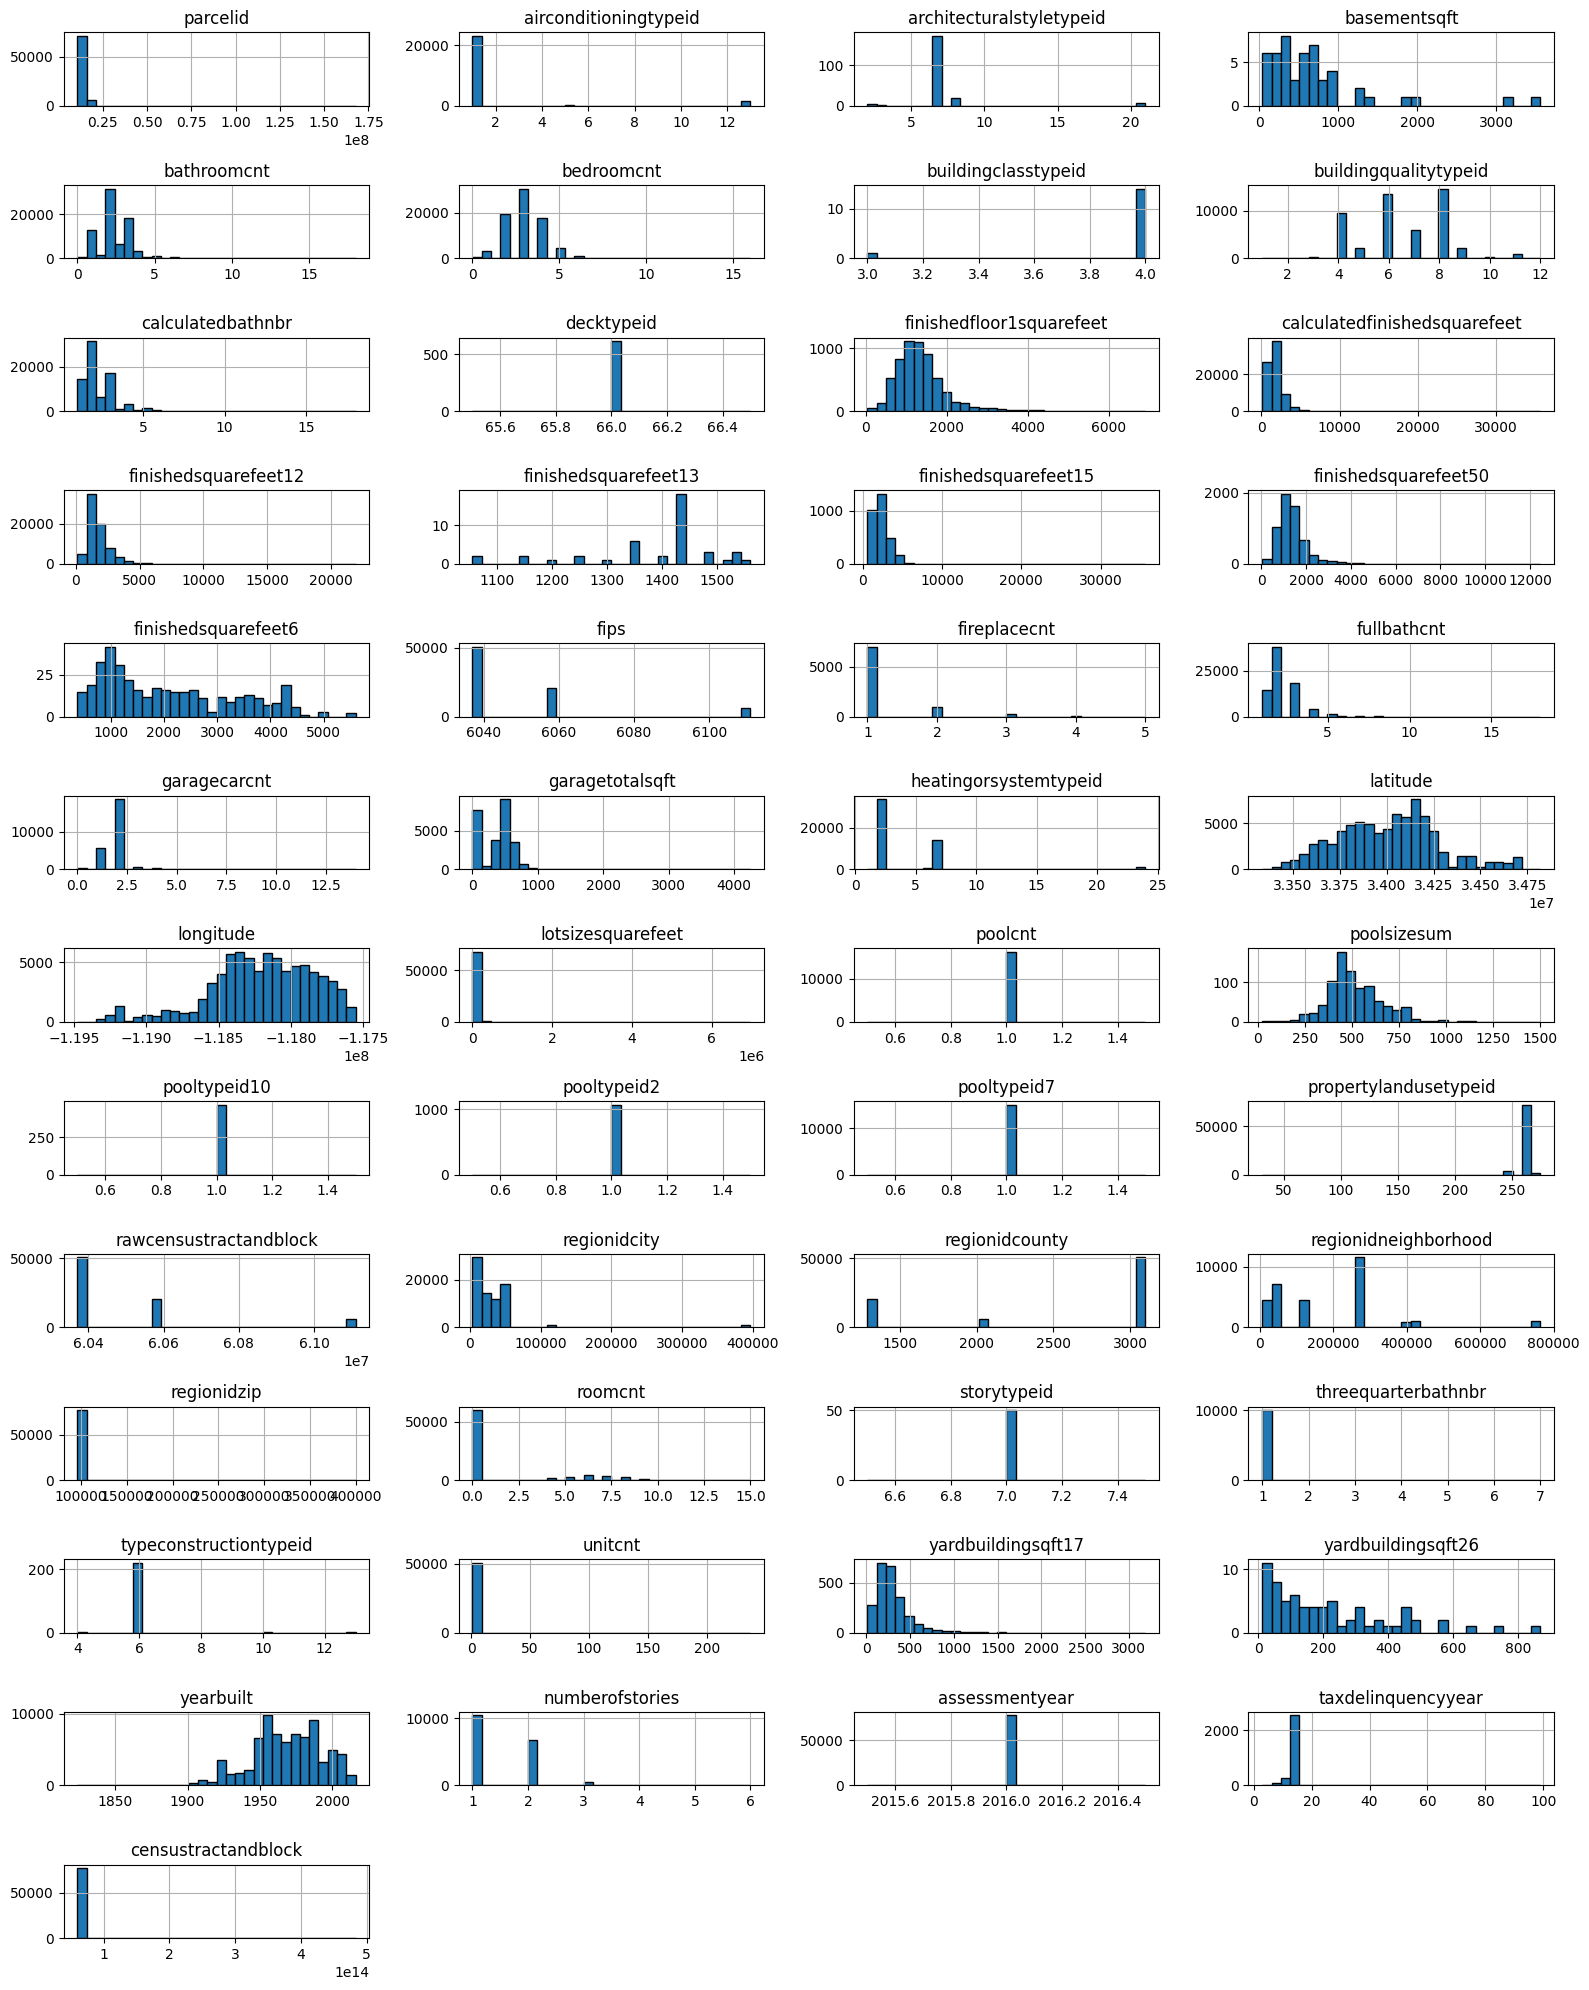

In [ ]:
# Plot features

# # Set number of columns for layout
m = 4

# Drop the target column from the numeric features (We will drop objects anyway)
features_to_plot = df.drop(columns=['taxvaluedollarcnt'])

# Plot histograms
features_to_plot.hist(figsize=(m * 4, 20), layout=(-1, m), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

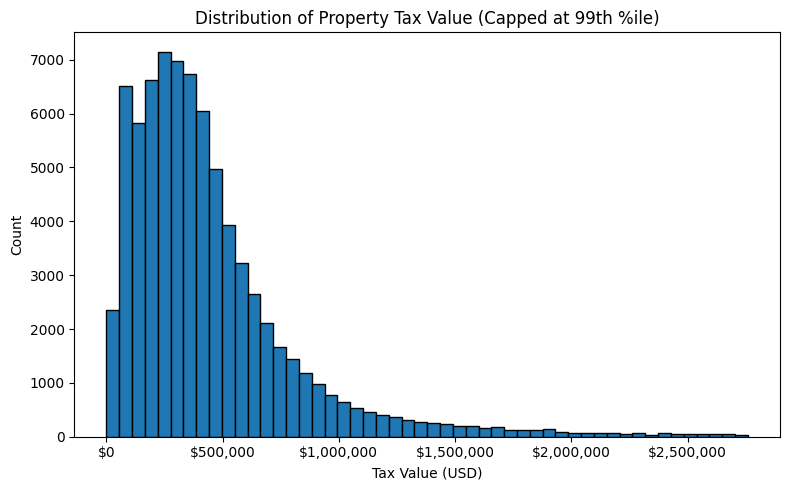

In [47]:
# Plot target

# # Drop NaNs and restrict to 99th percentile to avoid outliers skewing the view
taxval = df['taxvaluedollarcnt'].dropna()
taxval = taxval[taxval < taxval.quantile(0.99)]

plt.figure(figsize=(8, 5))
plt.hist(taxval, bins=50, edgecolor='black')
plt.title('Distribution of Property Tax Value (Capped at 99th %ile)')
plt.xlabel('Tax Value (USD)')
plt.ylabel('Count')

# Format y-axis with dollar commas
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.tight_layout()
plt.show()

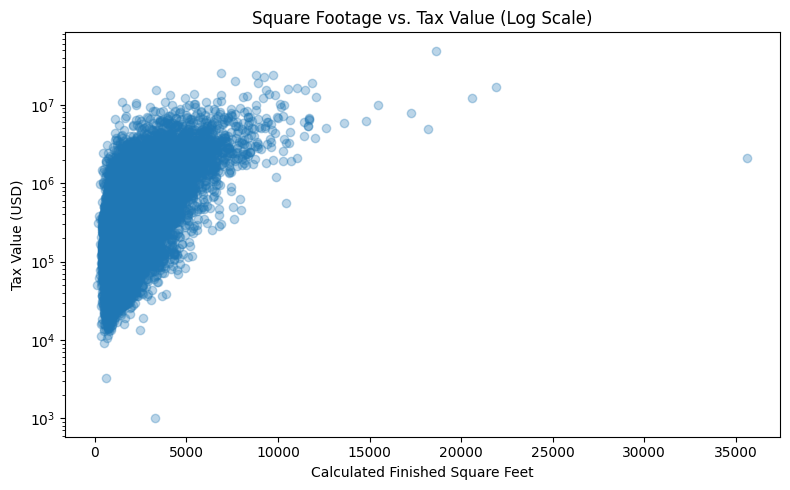

In [46]:
# Square Footage vs. Tax Value (Log Scale) Plot 

plt.figure(figsize=(8, 5))
plt.scatter(
    df['calculatedfinishedsquarefeet'], 
    df['taxvaluedollarcnt'], 
    alpha=0.3
)
plt.yscale('log')
plt.title('Square Footage vs. Tax Value (Log Scale)')
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Tax Value (USD)')
plt.tight_layout()
plt.show()

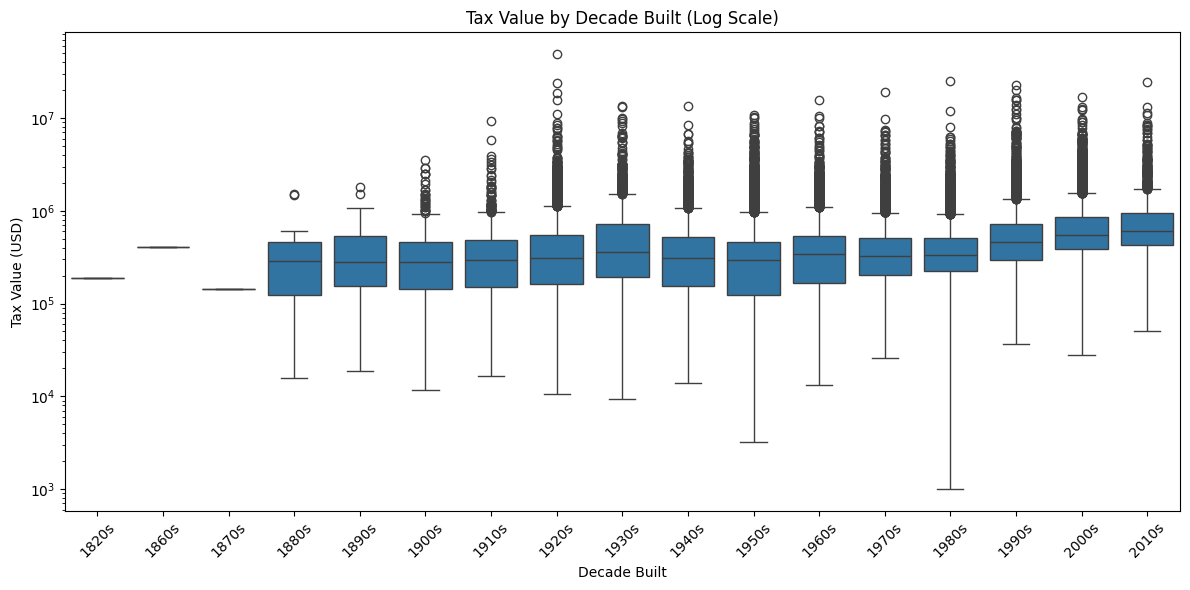

In [ ]:
# Tax Value by Decade Built (Log Scale) Plot

# Create labeled decade column
df_decade = df.dropna(subset=['yearbuilt']).copy()
df_decade['decade_built'] = (df_decade['yearbuilt'] // 10) * 10
df_decade['decade_label'] = df_decade['decade_built'].astype(int).astype(str) + 's'

# Create sorted order for x-axis
ordered_decades = sorted(df_decade['decade_label'].unique(), key=lambda x: int(x.rstrip('s')))

# Plot with correct order
plt.figure(figsize=(12, 6))
sns.boxplot(x='decade_label', y='taxvaluedollarcnt', data=df_decade, order=ordered_decades)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Tax Value by Decade Built (Log Scale)')
plt.xlabel('Decade Built')
plt.ylabel('Tax Value (USD)')
plt.tight_layout()
plt.show()

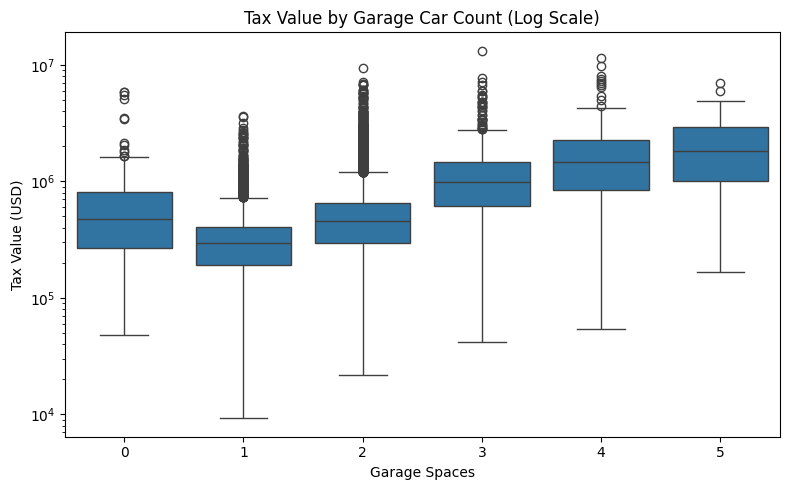

In [ ]:
# Tax Value by Garage Car Count (Log Scale) Plot

# Drop missing values for garagecarcnt and taxvaluedollarcnt
df_garage = df.dropna(subset=['garagecarcnt', 'taxvaluedollarcnt'])

# Filter to reasonable garage counts (e.g., 0 to 5)
df_garage = df_garage[df_garage['garagecarcnt'] <= 5]

# Convert to integer for clearer plotting
df_garage['garagecarcnt'] = df_garage['garagecarcnt'].astype(int)

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='garagecarcnt', y='taxvaluedollarcnt', data=df_garage)
plt.yscale('log')
plt.title('Tax Value by Garage Car Count (Log Scale)')
plt.xlabel('Garage Spaces')
plt.ylabel('Tax Value (USD)')
plt.tight_layout()
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Through detailed visual exploration, we observed that the distribution of the target variable `taxvaluedollarcnt` is highly right-skewed and resembles an exponential distribution, with most properties clustered below $1 million and a long tail of high-value outliers. The relationship between `calculatedfinishedsquarefeet` and tax value is positively correlated, but noisy — especially for larger homes - and the log scale revealed a clearer upward trend. The boxplot by `yearbuilt` (grouped by decade) showed that newer homes generally have higher valuations, though there is wide variability across all decades. Interestingly, the number of garage spaces (`garagecarcnt`) also showed a clear upward trend in tax value, with each additional space roughly associated with higher property value, up to about 4–5 cars. These features were chosen for their intuitive connection to home value, and they confirm expectations while also highlighting potential outliers and heteroscedasticity that we may need to address in modeling.


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [78]:
def drop_unsuitable_features(df, exceptions=None, drop_cols=None):
    """
    Drops object-type columns, single-unique-value columns, and any explicitly provided columns,
    unless they are listed in the exceptions.
    
    Parameters:
    - df: pandas DataFrame
    - exceptions: list of column names to keep regardless of drop rules
    - drop_cols: list of additional columns to drop for business logic or data leakage reasons
    """
    if exceptions is None:
        exceptions = []
    
    if drop_cols is None:
        drop_cols = [
            'calculatedbathnbr', 'fullbathcnt', 'unitcnt',
            'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
            'airconditioningtypeid', 'heatingorsystemtypeid', 'buildingqualitytypeid',
            'censustractandblock', 'latitude', 'longitude', 'regionidneighborhood'
        ]
    
    df_clean = df.copy()

    # Drop object-type columns unless in exceptions
    obj_cols = [col for col in df_clean.select_dtypes(include='object').columns if col not in exceptions]
    df_clean = df_clean.drop(columns=obj_cols)

    # Drop columns with only one unique value unless in exceptions
    for col in df_clean.columns:
        if col not in exceptions and df_clean[col].nunique(dropna=True) <= 1:
            df_clean = df_clean.drop(columns=[col])

    # Drop additional specified columns unless in exceptions
    drop_cols_filtered = [col for col in drop_cols if col not in exceptions]
    df_clean = df_clean.drop(columns=[col for col in drop_cols_filtered if col in df_clean.columns])

    return df_clean


In [79]:
df_part3a = drop_unsuitable_features(df, exceptions=['poolcnt'])
df_part3a.shape

(77613, 35)

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 

In this step, we dropped several features based on their lack of usefulness for a regression task. All features of type object were removed since they are not directly usable in numerical modeling without encoding, and most were either sparse or non-informative (e.g., text IDs or high-cardinality zoning codes). We also dropped any feature with only one unique value, as they provide no variation for the model to learn from — with the exception of `poolcnt`, which we plan to use as a binary indicator of whether a pool exists. Additional features were removed for business logic reasons. These included components of the target (`structuretaxvaluedollarcnt`, `landtaxvaluedollarcnt`, and `taxvaluedollarcnt`) to prevent data leakage, and features like `unitcnt`, `calculatedbathnbr`, and `fullbathcnt` which are either redundant or sparsely populated. Lastly, geographic codes such as `censustractandblock`, `latitude`, and `longitude` were removed due to high cardinality and lack of immediate interpretability or modeling relevance. These decisions help reduce noise and simplify the dataset while retaining features with the most predictive potential.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [80]:
def drop_high_missing(df, threshold=0.8, exceptions=None):
    """
    Drops columns with more than a given percentage of missing values,
    except for any explicitly listed exceptions.
    """
    if exceptions is None:
        exceptions = []

    # Calculate missingness
    missing_percent = df.isnull().mean()

    # Identify columns to drop (above threshold, not in exceptions)
    to_drop = [col for col in missing_percent.index 
               if (missing_percent[col] > threshold) and (col not in exceptions)]
    
    return df.drop(columns=to_drop)


In [81]:
# Apply to result of Part 3.A
df_part3b = drop_high_missing(df_part3a, threshold=0.8, exceptions=['fireplacecnt'])
df_part3b.shape

(77613, 21)

In [82]:
# Remaining columns
df_part3b.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fireplacecnt', 'garagecarcnt',
       'garagetotalsqft', 'lotsizesquarefeet', 'poolcnt',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'numberofstories', 'taxvaluedollarcnt', 'decade_built'],
      dtype='object')

In [87]:
# Drop 'yearbuilt' (since we're using 'decade_built')
df_part3b = df_part3b.drop(columns=['yearbuilt'], errors='ignore')

df_part3b.shape

(77613, 20)

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



In this step, we dropped features with more than 80% missing values, as they are unlikely to contribute meaningful or reliable information to the regression model. The threshold of 80% was chosen to strike a balance between retaining useful data and avoiding excessive imputation that could introduce noise. Features with extreme missingness are often too sparse to be trusted, especially when their meaning or distribution is unclear. An exception was made for `fireplacecnt`, which—despite its high rate of missingness—can be converted into a binary flag to indicate the presence or absence of a fireplace. This decision was based on business relevance, as having a fireplace could still impact a property's value even if detailed counts are sparse. Lastly, we dropped the `yearbuilt` column since a more interpretable version, `decade_built`, had already been created and captures the same information in a less granular form.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [83]:
def drop_invalid_rows(df, target='taxvaluedollarcnt', target_max_quantile=0.99):
    """
    Drops rows with missing target values and outliers in the target column.
    """
    df_clean = df.copy()

    # Drop rows with missing target
    df_clean = df_clean.dropna(subset=[target])

    # Drop rows with outlier target values (above 99th percentile)
    upper_bound = df_clean[target].quantile(target_max_quantile)
    df_clean = df_clean[df_clean[target] <= upper_bound]

    return df_clean


In [88]:
# Remove rows with null target or outlier target values
df_part3c = drop_invalid_rows(df_part3b)

In [89]:
df_part3c.shape

(76802, 20)

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


In this step, we dropped rows that were unsuitable for modeling. Specifically, any rows with missing values in the target variable `taxvaluedollarcnt` were removed, as they cannot be used in a supervised regression task. We also removed rows with extreme outliers in the target, defined as values above the 99th percentile, to prevent a small number of high-value properties from skewing the model.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [ ]:
def impute_values(df):
    """
    Applies column-specific imputations:
    - Median for numeric/skewed features
    - Mode for regional identifiers
    - Zero where missing implies absence
    """
    df_imputed = df.copy()

    # Impute with 0 where missing means absence
    zero_fill_cols = ['poolcnt', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'numberofstories']
    for col in zero_fill_cols:
        if col in df_imputed.columns:
            df_imputed[col] = df_imputed[col].fillna(0)

    # Impute with median for numeric values
    median_fill_cols = [
        'bathroomcnt', 'bedroomcnt', 'roomcnt', 
        'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 
        'lotsizesquarefeet', 'yearbuilt', 'decade_built'
    ]
    for col in median_fill_cols:
        if col in df_imputed.columns:
            median = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median)

    # Impute with mode for categorical/region identifiers
    mode_fill_cols = [
        'fips', 'propertylandusetypeid', 'regionidcity', 
        'regionidcounty', 'regionidzip', 'rawcensustractandblock'
    ]
    for col in mode_fill_cols:
        if col in df_imputed.columns:
            mode = df_imputed[col].mode(dropna=True)
            if not mode.empty:
                df_imputed[col] = df_imputed[col].fillna(mode[0])

    return df_imputed


In [95]:
df_part3d = impute_values(df_part3c)
df_part3d.isnull().sum().sort_values(ascending=False)

parcelid                        0
bathroomcnt                     0
taxvaluedollarcnt               0
numberofstories                 0
roomcnt                         0
regionidzip                     0
regionidcounty                  0
regionidcity                    0
rawcensustractandblock          0
propertylandusetypeid           0
poolcnt                         0
lotsizesquarefeet               0
garagetotalsqft                 0
garagecarcnt                    0
fireplacecnt                    0
fips                            0
finishedsquarefeet12            0
calculatedfinishedsquarefeet    0
bedroomcnt                      0
decade_built                    0
dtype: int64

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


To handle missing values in the dataset, we used different imputation strategies based on the nature and meaning of each feature. For numerical features such as square footage, lot size, and bathroom or bedroom counts, we used the median, as it is robust to outliers and better represents central tendency in skewed distributions. For regional identifiers like `fips`, `regionidzip`, and `propertylandusetypeid`, we used the mode. For features where missingness clearly indicates absence — such as `poolcnt`, `fireplacecnt`, `garagecarcnt`, and `numberofstories` - we imputed with zero, treating missing values as “none present.” This targeted approach ensures the dataset is complete while preserving the underlying meaning of each feature.


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [90]:
# We do not have any categorical features left

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

